In [84]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(rc = {'figure.figsize':(12,8)})
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
from sklearn.metrics import mean_squared_error,accuracy_score
from tqdm.notebook import tqdm ,tnrange
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [85]:
train_df = pd.read_excel('Data_Train.xlsx')
test_df = pd.read_excel('Test_Set.xlsx')

In [86]:
train_df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [87]:
train_df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [88]:
big_df  = train_df.append(test_df,sort=False)

In [89]:
big_df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897.0
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662.0
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882.0
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218.0
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302.0
...,...,...,...,...,...,...,...,...,...,...,...
2666,Air India,6/06/2019,Kolkata,Banglore,CCU → DEL → BLR,20:30,20:25 07 Jun,23h 55m,1 stop,No info,NaN
2667,IndiGo,27/03/2019,Kolkata,Banglore,CCU → BLR,14:20,16:55,2h 35m,non-stop,No info,NaN
2668,Jet Airways,6/03/2019,Delhi,Cochin,DEL → BOM → COK,21:50,04:25 07 Mar,6h 35m,1 stop,No info,NaN
2669,Air India,6/03/2019,Delhi,Cochin,DEL → BOM → COK,04:00,19:15,15h 15m,1 stop,No info,NaN


In [90]:
big_df['date_of_journey'] = big_df['Date_of_Journey'].str.split('/').str[0]
big_df['month_of_journey'] = big_df['Date_of_Journey'].str.split('/').str[1]
big_df = big_df.drop(['Date_of_Journey'],axis=1)
big_df['date_of_journey'] = big_df['date_of_journey'].astype(int)
big_df['month_of_journey'] = big_df['month_of_journey'].astype(int)


big_df['arrival_Time'] = big_df['Arrival_Time'].str.split(' ').str[0]
big_df = big_df.drop(['Arrival_Time'],1)

big_df['Total_Stops'] = big_df['Total_Stops'].fillna('1 stop')
big_df['Total_Stops'] = big_df['Total_Stops'].replace('non-stop','0 stop')
big_df['total_Stops'] = big_df['Total_Stops'].str.split(' ').str[0]
big_df = big_df.drop(['Total_Stops'],1)
big_df['total_Stops'] = big_df['total_Stops'].astype('int')

big_df['arrival_hour'] = big_df['arrival_Time'].str.split(':').str[0]
big_df['arrival_minute'] = big_df['arrival_Time'].str.split(':').str[1]
big_df['arrival_hour'] = big_df['arrival_hour'].astype('int')
big_df['arrival_minute'] = big_df['arrival_minute'].astype('int')
big_df = big_df.drop(['arrival_Time'],1)

big_df['Departure_Hour'] = big_df['Dep_Time'].str.split(':').str[0]
big_df['Departure_Minute'] = big_df['Dep_Time'].str.split(':').str[1]
big_df['Departure_Hour'] = big_df['Departure_Hour'].astype('int')
big_df['Departure_Minute'] = big_df['Departure_Minute'].astype('int')
big_df = big_df.drop(['Dep_Time'],axis=1)

big_df['Duration_Hour'] = big_df['Duration'].str.split(' ').str[0]
big_df['Duration_Minute'] = big_df['Duration'].str.split(' ').str[1]
big_df['Duration_Hour']= big_df['Duration_Hour'].str.split('h').str[0]
big_df['Duration_Minute'] = big_df['Duration_Minute'].str.split('m').str[0]
big_df['Duration_Minute'] = big_df['Duration_Minute'].fillna(0)
big_df['Duration_Hour'] = big_df['Duration_Hour'].fillna(0)
big_df = big_df.drop(['Duration'],1)

big_df['Duration_Minute'] = big_df['Duration_Minute'].astype(int)
big_df['Duration_Hour'] = big_df['Duration_Hour'].str.split('m').str[0]
big_df['Duration_Hour'] = big_df['Duration_Hour'].astype(int)

In [91]:
big_df

,Airline,Source,Destination,Route,Additional_Info,Price,date_of_journey,month_of_journey,total_Stops,arrival_hour,arrival_minute,Departure_Hour,Departure_Minute,Duration_Hour,Duration_Minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,No info,3897.0,24,3,0,1,10,22,20,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,No info,7662.0,1,5,2,13,15,5,50,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,No info,13882.0,9,6,2,4,25,9,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,No info,6218.0,12,5,1,23,30,18,5,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,No info,13302.0,1,3,1,21,35,16,50,4,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,Air India,Kolkata,Banglore,CCU → DEL → BLR,No info,NaN,6,6,1,20,25,20,30,23,55
2667,IndiGo,Kolkata,Banglore,CCU → BLR,No info,NaN,27,3,0,16,55,14,20,2,35
2668,Jet Airways,Delhi,Cochin,DEL → BOM → COK,No info,NaN,6,3,1,4,25,21,50,6,35
2669,Air India,Delhi,Cochin,DEL → BOM → COK,No info,NaN,6,3,1,19,15,4,0,15,15


In [92]:
big_df.drop(['Route','Additional_Info'],1,inplace=True)

<Figure size 1152x864 with 0 Axes>

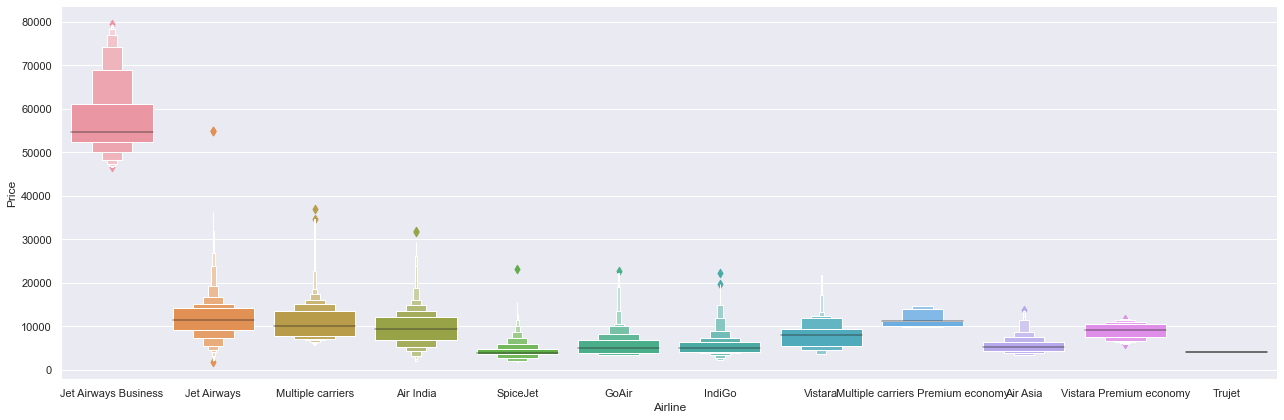

In [93]:
# Airline vs Price
plt.figure(figsize=(16,12))
sns.catplot(y = "Price", x = "Airline", data = train_df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

<Figure size 1152x864 with 0 Axes>

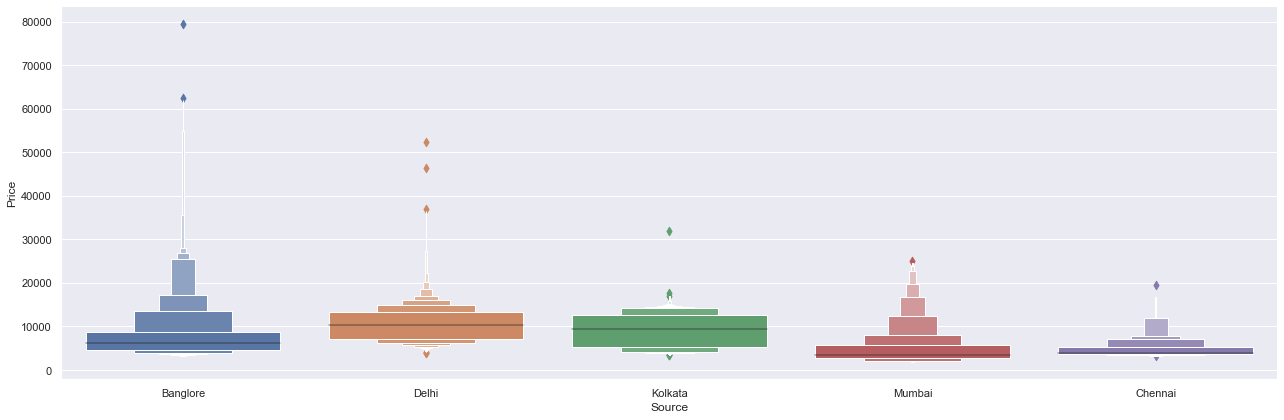

In [94]:
# Airline vs Price
plt.figure(figsize=(16,12))
sns.catplot(y = "Price", x = "Source", data = train_df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

In [95]:
featured_df = pd.get_dummies(big_df, columns=['Airline','Source','Destination'],drop_first=True )

In [96]:
featured_df

,Price,date_of_journey,month_of_journey,total_Stops,arrival_hour,arrival_minute,Departure_Hour,Departure_Minute,Duration_Hour,Duration_Minute,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,3897.0,24,3,0,1,10,22,20,2,50,...,0,0,0,0,0,0,0,0,0,1
1,7662.0,1,5,2,13,15,5,50,7,25,...,0,0,0,1,0,0,0,0,0,0
2,13882.0,9,6,2,4,25,9,25,19,0,...,0,0,1,0,0,1,0,0,0,0
3,6218.0,12,5,1,23,30,18,5,5,25,...,0,0,0,1,0,0,0,0,0,0
4,13302.0,1,3,1,21,35,16,50,4,45,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,NaN,6,6,1,20,25,20,30,23,55,...,0,0,0,1,0,0,0,0,0,0
2667,NaN,27,3,0,16,55,14,20,2,35,...,0,0,0,1,0,0,0,0,0,0
2668,NaN,6,3,1,4,25,21,50,6,35,...,0,0,1,0,0,1,0,0,0,0
2669,NaN,6,3,1,19,15,4,0,15,15,...,0,0,1,0,0,1,0,0,0,0


In [97]:
big_df.isnull().sum()

Airline                0
Source                 0
Destination            0
Price               2671
date_of_journey        0
month_of_journey       0
total_Stops            0
arrival_hour           0
arrival_minute         0
Departure_Hour         0
Departure_Minute       0
Duration_Hour          0
Duration_Minute        0
dtype: int64

In [98]:
train_df.shape

(10683, 11)

In [99]:
train = featured_df[0:10683]
test = featured_df[10683:]

In [70]:
train.head()

,Price,date_of_journey,month_of_journey,Departure_Hour,Departure_Minute,arrival_hour,arrival_minute,Duration_Hour,Duration_Minute,Airline_Air India,...,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,total_Stops
0,3897.0,24,3,22,20,1,10,2,50,0,...,0,0,0,0,0,0,0,0,1,0
1,7662.0,1,5,5,50,13,15,7,25,1,...,0,0,1,0,0,0,0,0,0,2
2,13882.0,9,6,9,25,4,25,19,0,0,...,0,1,0,0,1,0,0,0,0,2
3,6218.0,12,5,18,5,23,30,5,25,0,...,0,0,1,0,0,0,0,0,0,1
4,13302.0,1,3,16,50,21,35,4,45,0,...,0,0,0,0,0,0,0,0,1,1


In [101]:
test.isnull().sum()

Price                                        2671
date_of_journey                                 0
month_of_journey                                0
total_Stops                                     0
arrival_hour                                    0
arrival_minute                                  0
Departure_Hour                                  0
Departure_Minute                                0
Duration_Hour                                   0
Duration_Minute                                 0
Airline_Air India                               0
Airline_GoAir                                   0
Airline_IndiGo                                  0
Airline_Jet Airways                             0
Airline_Jet Airways Business                    0
Airline_Multiple carriers                       0
Airline_Multiple carriers Premium economy       0
Airline_SpiceJet                                0
Airline_Trujet                                  0
Airline_Vistara                                 0


In [102]:
test = test.drop('Price',1)


In [103]:
X = train.drop('Price',1)
y = train['Price']

<AxesSubplot:>

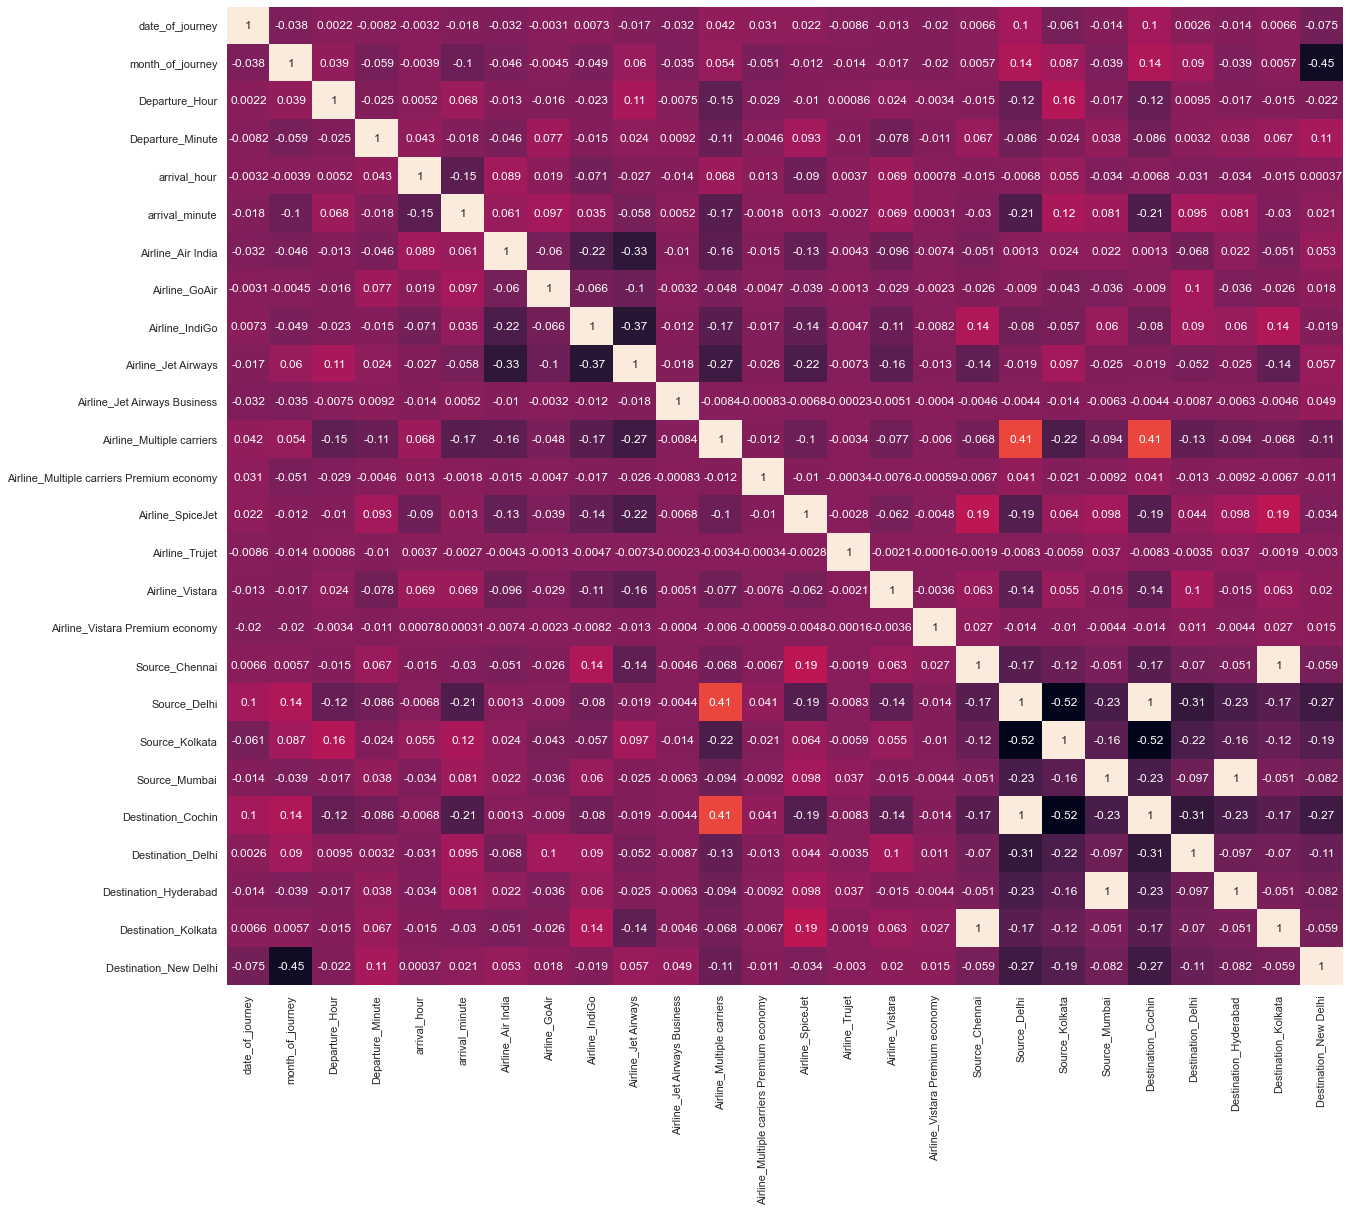

In [82]:
sns.set(rc={'figure.figsize':(20,18)})
sns.heatmap(X.corr(),annot=True,cbar=False)

In [104]:
from sklearn.ensemble import ExtraTreesRegressor
select = ExtraTreesRegressor()
select.fit(X,y)

ExtraTreesRegressor()

In [105]:
print(select.feature_importances_)

[1.42207185e-01 5.45159397e-02 2.39902197e-01 2.82071744e-02
 1.89563953e-02 2.37691392e-02 2.12715561e-02 1.12073620e-01
 1.75015551e-02 9.55037615e-03 1.93699741e-03 1.86295788e-02
 1.39519170e-01 6.71889068e-02 1.90635229e-02 8.68591657e-04
 3.32058815e-03 1.26870183e-04 5.01893743e-03 7.60103620e-05
 4.02453657e-04 1.41037524e-02 3.50142426e-03 6.16863084e-03
 7.50768441e-03 1.36167302e-02 5.49743689e-03 5.25152572e-04
 2.49724245e-02]


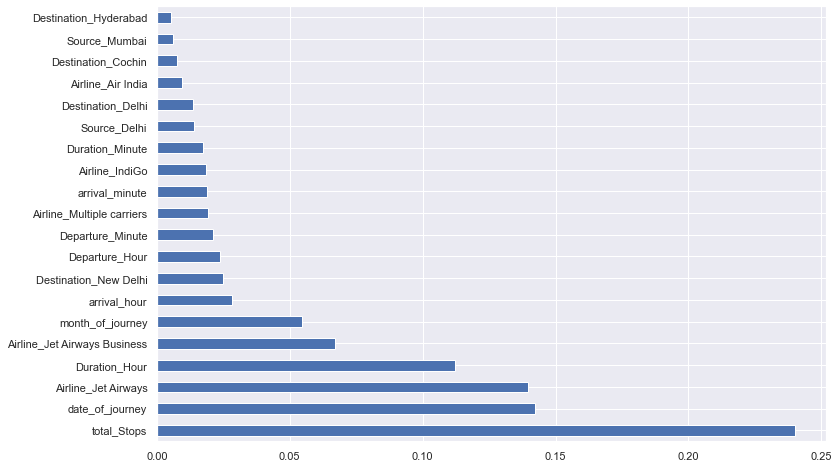

In [107]:
#plot graph of feature importances for better visualization

plt.figure(figsize = (12,8))
feat_importances = pd.Series(select.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()


In [116]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size = 0.2,random_state  =42)

In [112]:
### Hyperparameter Tuning RandomCV
from sklearn.model_selection import RandomizedSearchCV
#Randomized Search CV
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [110]:
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [113]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = reg_rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [117]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.0s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.0s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.0s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.0s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.0s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=   4.6s
[CV] n_estimators=1100, min_samples_split=10, mi

[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.6s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.5s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.6s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.6s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.5s
[CV] n_estimators=700, min_samples_split=15, min_sam

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.7min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [118]:
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [119]:
prediction = rf_random.predict(test)

In [124]:
# SAVING MODEL 
import pickle
# open a file, where you ant to store the data
file = open('flight_rf.pkl', 'wb')

# dump information to that file
pickle.dump(rf_random, file)

In [125]:
model = open('flight_rf.pkl','rb')
forest = pickle.load(model)

In [128]:
y_prediction = forest.predict(X_test)

In [129]:
from sklearn import metrics
metrics.r2_score(y_test, y_prediction)

0.8030918016698628